In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import random
import time
from tqdm.notebook import tqdm

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import GNNBenchmarkDataset
import networkx as nx
from scipy import sparse as sp

from models import NodeClassificationGraphTransformer, GraphTransformerEdges, GraphTransformer, GraphRegressionGraphTransformerEdges
from preprocess import AddLaplacianPosEncoding, AddWLPosEncoding, SBMDataset
from train import train_one_epoch, evaluate

In [2]:
SEED = 0

if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print('cuda not available')
    device = torch.device("cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)


cuda available with GPU: NVIDIA GeForce GTX 1660 Ti


# Parameters

In [9]:
# Dimension of positional encoding, ex number of non-trivial eigenvalues for laplacian positional encoding
POS_ENCODING_DIM = 10 # 2 / 10

# Training parameters
BATCH_SIZE = 32
INIT_LR = 0.0005
WEIGHT_DECAY = 0.0
LR_REDUCE_FACTOR = 0.5
PATIENCE = 10
MIN_LR = 1e-6
EPOCHS = 20

# Network parameters
n_hidden = 80
n_head = 8
n_feedforward = 160
n_layers = 4
input_dropout = 0.0
dropout = 0.0
norm = 'layer'
readout = 'mean'

# Data

In [4]:
# Dataset and prior transforms
data_transforms = T.Compose([
    SBMDataset(),
    AddLaplacianPosEncoding(POS_ENCODING_DIM),
    AddWLPosEncoding(),
    T.AddSelfLoops('edge_attr')
    ])

name = 'CLUSTER' # PATTERN / CLUSTER
dataset_train = GNNBenchmarkDataset('data/SBM', name, split='train', pre_transform=data_transforms)
dataset_val = GNNBenchmarkDataset('data/SBM', name, split='val', pre_transform=data_transforms)
dataset_test = GNNBenchmarkDataset('data/SBM', name, split='test', pre_transform=data_transforms)

In [5]:
# Dataloaders
dataloader_train = torch_geometric.loader.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = torch_geometric.loader.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch_geometric.loader.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# Vocabulary sizes for nodes, for embedding layers
n_classes = torch.unique(dataset_train.y).size(0)
n_nodes_input = n_classes+1

# Training and test

In [7]:
model = NodeClassificationGraphTransformer(n_nodes_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers,
                                             n_classes,
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM, 
                                             norm=norm)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=LR_REDUCE_FACTOR,
                                                 patience=PATIENCE,
                                                 verbose=True)

epoch_train_losses, epoch_val_losses = [], []
epoch_train_accs, epoch_val_accs = [], [] 

In [10]:
for epoch in range(EPOCHS):
    
    epoch_train_loss, epoch_train_acc, optimizer = train_one_epoch(model, dataloader_train, epoch, device, optimizer, criterion, accuracy=True)

    epoch_val_loss, epoch_val_acc = evaluate(model, dataloader_val, device, criterion, accuracy=True) 

    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    epoch_train_accs.append(epoch_train_acc)
    epoch_val_accs.append(epoch_val_acc)

    lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{EPOCHS}: Train loss = {epoch_train_loss:.4f}, Validation loss = {epoch_val_loss:.4f}, Train accuracy = {epoch_train_acc:.4f}, Validation accuracy = {epoch_val_acc:.4f}, Learning rate = {lr}')

Epoch 20/20: Train loss = 1.1227, Validation loss = 1.1278, Train accuracy = 0.5827, Validation accuracy = 0.5810, Learning rate = 0.0005


In [11]:
epoch_test_loss = evaluate(model, dataloader_test, device, criterion, accuracy=True)
epoch_test_loss

(1.12811641395092, 0.5821182075887918)

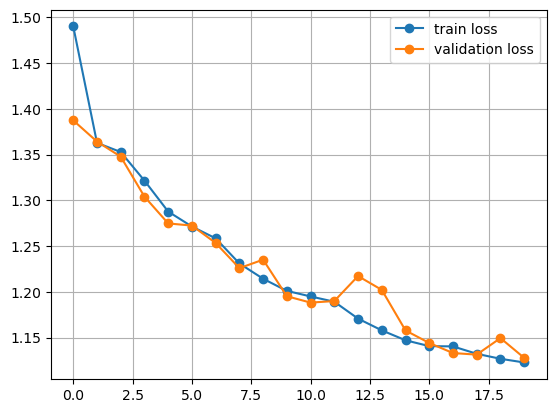

In [12]:
plt.plot(range(EPOCHS), epoch_train_losses, '-o', label='train loss')
plt.plot(range(EPOCHS), epoch_val_losses, '-o', label='validation loss')
plt.legend()
plt.grid()

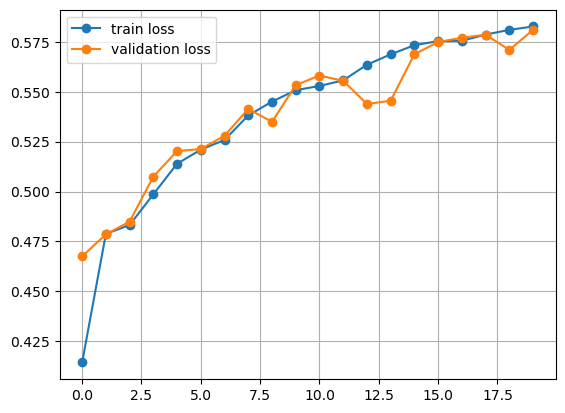

In [13]:
plt.plot(range(EPOCHS), epoch_train_accs, '-o', label='train loss')
plt.plot(range(EPOCHS), epoch_val_accs, '-o', label='validation loss')
plt.legend()
plt.grid()

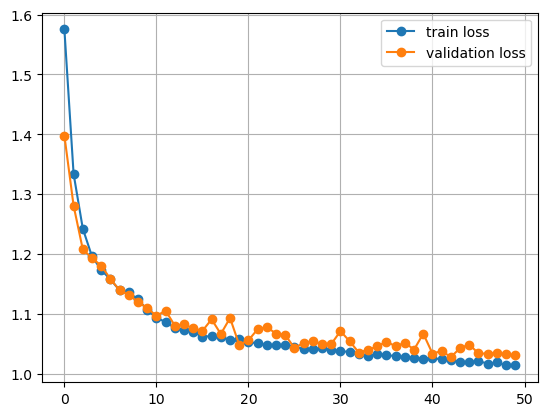

In [10]:
plt.plot(range(EPOCHS), epoch_train_losses, '-o', label='train loss')
plt.plot(range(EPOCHS), epoch_val_losses, '-o', label='validation loss')
plt.legend()
plt.grid()

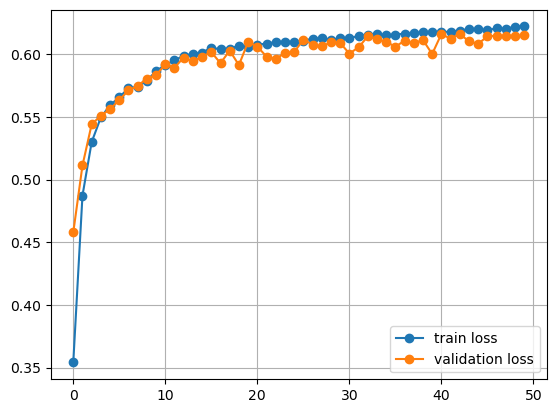

In [11]:
plt.plot(range(EPOCHS), epoch_train_accs, '-o', label='train loss')
plt.plot(range(EPOCHS), epoch_val_accs, '-o', label='validation loss')
plt.legend()
plt.grid()